# Jonathan Halverson
# Thursday, February 23, 2017
# Part 4: Winning percentage by age

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('halverson')
%matplotlib inline
from scipy.stats import binom

In [70]:
iofile = 'data/fightmetric_cards/fightmetric_fights_CLEAN_3-6-2017.csv'
fights = pd.read_csv(iofile, header=0, parse_dates=['Date'])
fights.head(3)

,Winner,Outcome,Loser,WeightClass,Method,MethodNotes,Round,Time,Event,Date,Location
0,Germaine de Randamie,def.,Holly Holm,Women's Featherweight,U-DEC,NaN,5,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA"
1,Anderson Silva,def.,Derek Brunson,Middleweight,U-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA"
2,Jacare Souza,def.,Tim Boetsch,Middleweight,SUB,Kimura,1,3:41,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA"


In [71]:
fights.shape

(4068, 11)

In [72]:
iofile = 'data/fightmetric_fighters_with_corrections_from_UFC_Wikipedia_CLEAN.csv'
fighters = pd.read_csv(iofile, header=0, parse_dates=['Dob'])
fighters.head(3)

,Name,Nickname,Dob,Weight,Height,Reach,LegReach,Stance,Win,Loss,Draw
0,Tom Aaron,NaN,1978-07-13,155.0,NaN,NaN,NaN,NaN,5.0,3.0,0.0
1,Danny Abbadi,The Assassin,1983-07-03,155.0,71.0,NaN,NaN,Orthodox,4.0,6.0,0.0
2,David Abbott,Tank,NaT,265.0,72.0,NaN,NaN,Switch,10.0,14.0,0.0


In [73]:
cols = ['Name', 'Weight', 'Height', 'Reach', 'LegReach', 'Stance', 'Dob']
df = fights.merge(fighters[cols], how='left', left_on='Winner', right_on='Name')
df.shape

(4068, 18)

In [74]:
df.head(3)

,Winner,Outcome,Loser,WeightClass,Method,MethodNotes,Round,Time,Event,Date,Location,Name,Weight,Height,Reach,LegReach,Stance,Dob
0,Germaine de Randamie,def.,Holly Holm,Women's Featherweight,U-DEC,NaN,5,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",Germaine de Randamie,145.0,69.0,71.0,41.0,Orthodox,1984-04-24
1,Anderson Silva,def.,Derek Brunson,Middleweight,U-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",Anderson Silva,185.0,74.0,77.0,42.0,Southpaw,1975-04-14
2,Jacare Souza,def.,Tim Boetsch,Middleweight,SUB,Kimura,1,3:41,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",Jacare Souza,185.0,73.0,72.0,41.0,Orthodox,1979-12-07


In [75]:
df = df.merge(fighters[cols], how='left', left_on='Loser', right_on='Name', suffixes=('', '_L'))
df.shape

(4068, 25)

In [76]:
df.head(3)

,Winner,Outcome,Loser,WeightClass,Method,MethodNotes,Round,Time,Event,Date,...,LegReach,Stance,Dob,Name_L,Weight_L,Height_L,Reach_L,LegReach_L,Stance_L,Dob_L
0,Germaine de Randamie,def.,Holly Holm,Women's Featherweight,U-DEC,NaN,5,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,...,41.0,Orthodox,1984-04-24,Holly Holm,145.0,68.0,69.0,38.0,Southpaw,1981-10-17
1,Anderson Silva,def.,Derek Brunson,Middleweight,U-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,...,42.0,Southpaw,1975-04-14,Derek Brunson,185.0,73.0,77.0,43.0,Southpaw,1984-01-04
2,Jacare Souza,def.,Tim Boetsch,Middleweight,SUB,Kimura,1,3:41,UFC 208: Holm vs. De Randamie,2017-02-11,...,41.0,Orthodox,1979-12-07,Tim Boetsch,185.0,72.0,74.0,42.0,Orthodox,1981-01-28


In [77]:
df = df.drop(['Name', 'Name_L'], axis=1)

### How many fights do we not have age information for?

In [78]:
df[(pd.isnull(df.Dob)) | (pd.isnull(df.Dob_L))].shape[0]

177

Note that most of the missing info is for fights before 2005.

### Let's compute win ratios by age bracket

In [79]:
wins = df[(df.Outcome == 'def.') & (df.Date > np.datetime64('2005-01-01')) & pd.notnull(df.Dob) & pd.notnull(df.Dob_L)].copy()
wins['Age'] = (wins.Date - wins.Dob) / np.timedelta64(1, 'Y')
wins['Age_L'] = (wins.Date - wins.Dob_L) / np.timedelta64(1, 'Y')

In [80]:
msk1 = wins.Age < 25
msk2 = wins.Age_L < 25
under25 = float(wins[msk1].shape[0]) / wins[msk1 | msk2].shape[0]
under25

0.6242038216560509

In [81]:
wins[msk1].shape[0], wins[msk2].shape[0]

(490, 371)

In [82]:
2 * binom.cdf(p=0.5, n=wins[msk1].shape[0] + wins[msk2].shape[0], k=min(wins[msk1].shape[0], wins[msk2].shape[0]))

5.6403070046415983e-05

In [83]:
msk1 = (wins.Age >= 25) & (wins.Age <= 29)
msk2 = (wins.Age_L >= 25) & (wins.Age_L <= 29)
over25under30 = float(wins[msk1].shape[0]) / wins[msk1 | msk2].shape[0]
over25under30

0.6313905930470347

In [84]:
wins[msk1].shape[0], wins[msk2].shape[0]

(1235, 1118)

In [85]:
2 * binom.cdf(p=0.5, n=wins[msk1].shape[0] + wins[msk2].shape[0], k=min(wins[msk1].shape[0], wins[msk2].shape[0]))

0.016767285469014539

In [86]:
msk1 = (wins.Age >= 30) & (wins.Age < 35)
msk2 = (wins.Age_L >= 30) & (wins.Age_L < 35)
over30under35 = float(wins[msk1].shape[0]) / wins[msk1 | msk2].shape[0]
over30under35

0.5838264299802761

In [87]:
wins[msk1].shape[0], wins[msk2].shape[0]

(1184, 1310)

In [88]:
2 * binom.cdf(p=0.5, n=wins[msk1].shape[0] + wins[msk2].shape[0], k=min(wins[msk1].shape[0], wins[msk2].shape[0]))

0.012299040431129078

In [89]:
msk1 = wins.Age >= 35
msk2 = wins.Age_L >= 35
over35 = float(wins[msk1].shape[0]) / wins[msk1 | msk2].shape[0]
over35

0.47126436781609193

In [90]:
wins[msk1].shape[0], wins[msk2].shape[0]

(287, 394)

In [91]:
2 * binom.cdf(p=0.5, n=wins[msk1].shape[0] + wins[msk2].shape[0], k=min(wins[msk1].shape[0], wins[msk2].shape[0]))

4.7073513370514293e-05

In [92]:
wins[msk1 & msk2][['Winner', 'Loser', 'Age', 'Age_L']].shape[0]

72

In [93]:
msk1 = (wins.Age > 35) & (wins.Age_L < 35)
msk2 = (wins.Age_L > 35) & (wins.Age < 35)
over35 = float(wins[msk1].shape[0]) / wins[msk1 | msk2].shape[0]
over35

0.40037243947858475

In [94]:
wins[msk1].shape[0], wins[msk2].shape[0]

(215, 322)

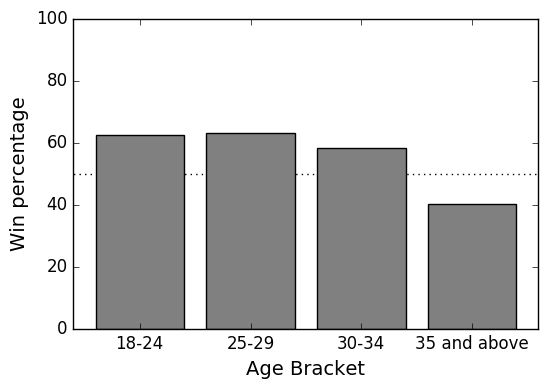

In [95]:
win_percent = [under25, over25under30, over30under35, over35]
labels = ['18-24', '25-29', '30-34', '35 and above']
plt.plot([-1, 4], [50, 50], 'k:', zorder=0)
plt.bar(range(len(win_percent)), 100 * np.array(win_percent), color='gray', tick_label=labels, align='center')
plt.xlim(-0.6, 3.6)
plt.ylim(0, 100)
plt.ylabel('Win percentage')
plt.xlabel('Age Bracket')

### What is the winning percentage by age?

In [96]:
wins['Age_int'] = wins.Age.astype(int)
wins['Age_L_int'] = wins.Age_L.astype(int)
win_count_by_age = wins.Age_int.value_counts()

# count fights per age without double counting
ages = win_count_by_age.index
counts = []
for age in ages:
     ct = wins[(wins.Age_int == age) | (wins.Age_L_int == age)].shape[0]
     counts.append(ct)
#total_count_by_age = pd.Series(data=counts, index=ages)
# win percentage is number of wins by age o
total_count_by_age = win_count_by_age + wins.Age_L_int.value_counts()
win_percent_by_age = win_count_by_age / total_count_by_age
print pd.concat([win_count_by_age, total_count_by_age, win_percent_by_age], axis=1).sort_index()

    Age_int      0         1
18      NaN    NaN       NaN
19      3.0    4.0  0.750000
20     16.0   27.0  0.592593
21     36.0   61.0  0.590164
22     85.0  152.0  0.559211
23    144.0  256.0  0.562500
24    206.0  360.0  0.572222
25    243.0  465.0  0.522581
26    300.0  571.0  0.525394
27    354.0  637.0  0.555730
28    338.0  680.0  0.497059
29    334.0  671.0  0.497765
30    333.0  650.0  0.512308
31    303.0  610.0  0.496721
32    243.0  517.0  0.470019
33    174.0  385.0  0.451948
34    131.0  332.0  0.394578
35    102.0  225.0  0.453333
36     75.0  184.0  0.407609
37     49.0  113.0  0.433628
38     23.0   58.0  0.396552
39     15.0   36.0  0.416667
40      8.0   21.0  0.380952
41      4.0   12.0  0.333333
42      2.0   11.0  0.181818
43      2.0    6.0  0.333333
44      3.0    5.0  0.600000
45      1.0    4.0  0.250000
46      2.0    4.0  0.500000
47      1.0    2.0  0.500000


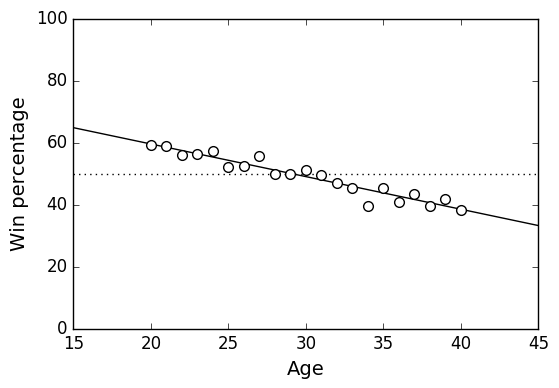

In [97]:
x = win_percent_by_age[total_count_by_age > 20].index
y = 100 * win_percent_by_age[total_count_by_age > 20].values
xmin = 15
xmax = 45

m, b = np.polyfit(x, y, 1)
plt.plot([xmin, xmax], [50, 50], 'k:')
plt.plot(np.linspace(xmin, xmax), m * np.linspace(xmin, xmax) + b, 'k-')
plt.plot(x, y, 'wo', ms=7)
plt.xlabel('Age')
plt.ylabel('Win percentage')
plt.xlim(15, 45)
plt.ylim(0, 100)
plt.savefig('report/age/win_percent_vs_age.pdf', bbox_inches='tight')

In [98]:
from scipy.stats import pearsonr, spearmanr

corr_pearson, p_value_pearson = pearsonr(x, y)
corr_spearman, p_value_spearman = spearmanr(x, y)
print corr_pearson, p_value_pearson
print corr_spearman, p_value_spearman

-0.958195395991 8.86813032089e-12
-0.955844155844 1.47771971719e-11


In [99]:
w = win_count_by_age[total_count_by_age > 20].sort_index()
t = total_count_by_age[total_count_by_age > 20].sort_index()
cont_table = pd.DataFrame({'wins':w, 'total':t}).T.sort_index(ascending=False)
cont_table

,20,21,22,23,24,25,26,27,28,29,...,31,32,33,34,35,36,37,38,39,40
wins,16.0,36.0,85.0,144.0,206.0,243.0,300.0,354.0,338.0,334.0,...,303.0,243.0,174.0,131.0,102.0,75.0,49.0,23.0,15.0,8.0
total,27.0,61.0,152.0,256.0,360.0,465.0,571.0,637.0,680.0,671.0,...,610.0,517.0,385.0,332.0,225.0,184.0,113.0,58.0,36.0,21.0


In [100]:
from scipy.stats import chi2_contingency

chi_sq, p_value, dof, expect = chi2_contingency(cont_table)
print chi_sq, p_value, p_value > 0.05

21.1560884485 0.387997046214 True


Below we compute Cramer's V which is a measure of the strength between the two nominal variables:

In [101]:
N = cont_table.sum().sum()
V = (chi_sq / (N * min(2 - 1, 21 - 1)))**0.5
V

0.044838172331606731

The above statistical test indicates that there is not enough data to conclude that the counts for each age are not due to chance. Part of this maybe that the numbers are the largest in the middle where the win ratio is about 50%.

In [102]:
def two_sided_binom(x):
     wins = x[0]
     total = x[1]
     if wins / total == 0.5:
          return 1.0
     elif wins / total < 0.5:
          return 2 * binom.cdf(p=0.5, k=wins, n=total)
     else:
          return 2 * (1.0 - binom.cdf(p=0.5, k=wins-1, n=total))

In [103]:
cont_table.loc['p_value'] = cont_table.apply(two_sided_binom, axis=0)
cont_table.applymap(lambda x: round(x, 2))

,20,21,22,23,24,25,26,27,28,29,...,31,32,33,34,35,36,37,38,39,40
wins,16.00,36.0,85.00,144.00,206.00,243.00,300.00,354.00,338.00,334.00,...,303.0,243.00,174.00,131.0,102.00,75.00,49.00,23.00,15.00,8.00
total,27.00,61.0,152.00,256.00,360.00,465.00,571.00,637.00,680.00,671.00,...,610.0,517.00,385.00,332.0,225.00,184.00,113.00,58.00,36.00,21.00
p_value,0.44,0.2,0.17,0.05,0.01,0.35,0.24,0.01,0.91,0.94,...,0.9,0.19,0.07,0.0,0.18,0.01,0.19,0.15,0.41,0.38


We see that when we compute the p_values they are mostly above 0.05.

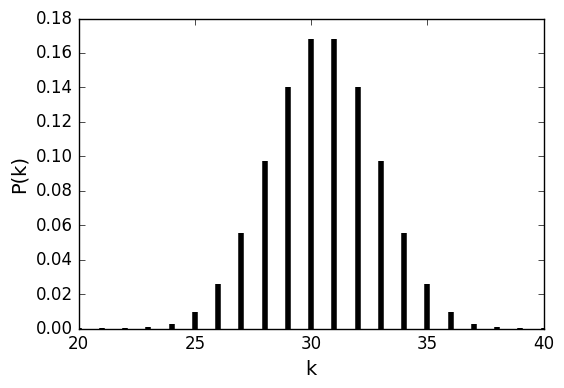

In [104]:
flips = 21
k_values = range(flips + 1)
plt.vlines(x, ymin=0, ymax=[binom.pmf(k, p=0.5, n=flips) for k in k_values], lw=4)
plt.xlabel('k')
plt.ylabel('P(k)')

### Let's compute the win percentage of the younger fighter as a function of age difference:

In [105]:
wins['AgeDiff'] = wins.Age_L - wins.Age
wins.AgeDiff = wins.AgeDiff.apply(round)
delta_age = wins.AgeDiff.value_counts().sort_index()
delta_age

-16.0      1
-15.0      1
-14.0      5
-13.0      9
-12.0     15
-11.0     17
-10.0     28
-9.0      37
-8.0      69
-7.0      97
-6.0     105
-5.0     139
-4.0     169
-3.0     207
-2.0     246
-1.0     287
 0.0     271
 1.0     257
 2.0     289
 3.0     287
 4.0     221
 5.0     185
 6.0     154
 7.0     119
 8.0      96
 9.0      77
 10.0     51
 11.0     29
 12.0     27
 13.0     12
 14.0     11
 15.0      7
 16.0      3
 17.0      2
Name: AgeDiff, dtype: int64

In [106]:
delta_age_overall = np.abs(wins.AgeDiff).value_counts().sort_index()
delta_age_overall

0.0     271
1.0     544
2.0     535
3.0     494
4.0     390
5.0     324
6.0     259
7.0     216
8.0     165
9.0     114
10.0     79
11.0     46
12.0     42
13.0     21
14.0     16
15.0      8
16.0      4
17.0      2
Name: AgeDiff, dtype: int64

In [107]:
younger_diff = delta_age.loc[0:17]
younger_diff

0.0     271
1.0     257
2.0     289
3.0     287
4.0     221
5.0     185
6.0     154
7.0     119
8.0      96
9.0      77
10.0     51
11.0     29
12.0     27
13.0     12
14.0     11
15.0      7
16.0      3
17.0      2
Name: AgeDiff, dtype: int64

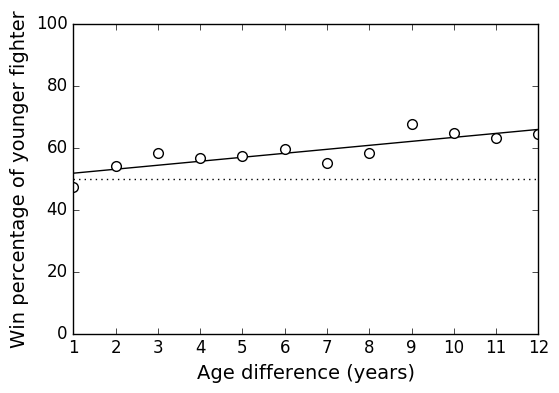

In [108]:
x = delta_age_overall.index
y = 100 * younger_diff / delta_age_overall
x = x.values[1:13]
y = y.values[1:13]
xmin = 1
xmax = 12

m, b = np.polyfit(x, y, 1)
plt.plot([xmin, xmax], [50, 50], 'k:')
plt.plot(np.linspace(xmin, xmax), m * np.linspace(xmin, xmax) + b, 'k-')
plt.plot(x, y, 'wo', ms=7)
plt.xlim(xmin, xmax)
plt.ylim(0, 100)
plt.xticks(range(1, 13))
plt.xlabel('Age difference (years)')
plt.ylabel('Win percentage of younger fighter')
plt.savefig('report/age/win_percent_of_younger.pdf', bbox_inches='tight')

Let's check the test case of 4:

In [109]:
wins[wins.AgeDiff == 4][['Winner', 'Loser', 'Age', 'Age_L', 'AgeDiff']].shape[0]

221

In [110]:
wins[wins.AgeDiff == -4][['Winner', 'Loser', 'Age', 'Age_L', 'AgeDiff']].shape[0]

169

In [111]:
221 / (221 + 169.0)

0.5666666666666667

This is the correct answer.

In [112]:
corr_pearson, p_value_pearson = pearsonr(x, y)
corr_spearman, p_value_spearman = spearmanr(x, y)
print corr_pearson, p_value_pearson
print corr_spearman, p_value_spearman

0.836782557943 0.000688864230938
0.832167832168 0.000785441677854


When the age difference is 1, we see the null hypothesis of independence holds:

In [113]:
binom.cdf(p=0.5, k=257, n=257+287)

0.10684763884684148

Let's create a table of the data:

In [114]:
older = delta_age.iloc[2:16]
older.index = older.index.map(abs)
older

14.0      5
13.0      9
12.0     15
11.0     17
10.0     28
9.0      37
8.0      69
7.0      97
6.0     105
5.0     139
4.0     169
3.0     207
2.0     246
1.0     287
Name: AgeDiff, dtype: int64

In [115]:
younger = delta_age.iloc[17:31]
younger

1.0     257
2.0     289
3.0     287
4.0     221
5.0     185
6.0     154
7.0     119
8.0      96
9.0      77
10.0     51
11.0     29
12.0     27
13.0     12
14.0     11
Name: AgeDiff, dtype: int64

The table below shows that number of wins by the older and younger fighter for the given age difference:

In [116]:
cont_table = pd.DataFrame([older, younger])
cont_table.index = ['older', 'younger']
cont_table

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0
older,287,246,207,169,139,105,97,69,37,28,17,15,9,5
younger,257,289,287,221,185,154,119,96,77,51,29,27,12,11


In [117]:
chi_sq, p_value, dof, expect = chi2_contingency(cont_table)
print chi_sq, p_value, p_value > 0.05

32.2035548642 0.00224088040429 False


In [118]:
N = cont_table.sum().sum()
V = (chi_sq / (N * min(2 - 1, 14 - 1)))**0.5
V

0.099619545709053139

In [119]:
def two_sided_binom(x):
     wins = float(x[0])
     total = x[0] + x[1]
     if wins / total == 0.5:
          return 1.0
     elif wins / total < 0.5:
          return 2 * binom.cdf(p=0.5, k=wins, n=total)
     else:
          return 2 * (1.0 - binom.cdf(p=0.5, k=wins-1, n=total))

In [120]:
cont_table.loc['p_value'] = cont_table.apply(two_sided_binom, axis=0)
cont_table.applymap(lambda x: round(x, 2))

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0
older,287.00,246.00,207.0,169.00,139.00,105.0,97.00,69.00,37.0,28.00,17.0,15.00,9.00,5.00
younger,257.00,289.00,287.0,221.00,185.00,154.0,119.00,96.00,77.0,51.00,29.0,27.00,12.00,11.00
p_value,0.21,0.07,0.0,0.01,0.01,0.0,0.15,0.04,0.0,0.01,0.1,0.09,0.66,0.21


# Youngest and oldest fighters

In [121]:
fights[fights.Winner == 'Robbie Lawler']

,Winner,Outcome,Loser,WeightClass,Method,MethodNotes,Round,Time,Event,Date,Location
527,Robbie Lawler,def.,Carlos Condit,Welterweight,S-DEC,NaN,5,5:00,UFC 195: Lawler vs Condit,2016-01-02,"Las Vegas, Nevada, USA"
765,Robbie Lawler,def.,Rory MacDonald,Welterweight,KO/TKO,Punch,5,1:00,UFC 189: Mendes vs McGregor,2015-07-11,"Las Vegas, Nevada, USA"
1047,Robbie Lawler,def.,Johny Hendricks,Welterweight,S-DEC,NaN,5,5:00,UFC 181: Hendricks vs Lawler II,2014-12-06,"Las Vegas, Nevada, USA"
1218,Robbie Lawler,def.,Matt Brown,Welterweight,U-DEC,NaN,5,5:00,UFC on Fox: Lawler vs Brown,2014-07-26,"San Jose, California, USA"
1339,Robbie Lawler,def.,Jake Ellenberger,Welterweight,KO/TKO,Knee,3,3:06,UFC 173: Barao vs Dillashaw,2014-05-24,"Las Vegas, Nevada, USA"
1560,Robbie Lawler,def.,Rory MacDonald,Welterweight,S-DEC,NaN,3,5:00,UFC 167: St-Pierre vs Hendricks,2013-11-16,"Las Vegas, Nevada, USA"
1704,Robbie Lawler,def.,Bobby Voelker,Welterweight,KO/TKO,Kick,2,0:24,UFC on Fox: Johnson vs Moraga,2013-07-27,"Seattle, Washington, USA"
1848,Robbie Lawler,def.,Josh Koscheck,Welterweight,KO/TKO,Punches,1,3:57,UFC 157: Rousey vs Carmouche,2013-02-23,"Anaheim, California, USA"
3663,Robbie Lawler,def.,Chris Lytle,Welterweight,U-DEC,NaN,3,5:00,UFC 45: Revolution,2003-11-21,"Uncasville, Connecticut, USA"
3704,Robbie Lawler,def.,Tiki Ghosn,Welterweight,KO/TKO,Punch,1,1:29,UFC 40: Vendetta,2002-11-22,"Las Vegas, Nevada, USA"


In [122]:
all_wins = df[pd.notnull(df.Dob)].copy()
all_wins['Age'] = (all_wins.Date - all_wins.Dob) / np.timedelta64(1, 'Y')

all_loses = df[pd.notnull(df.Dob_L)].copy()
all_loses['Age'] = (all_loses.Date - all_loses.Dob_L) / np.timedelta64(1, 'Y')

youngest_winners = all_wins.groupby('Winner').agg({'Age':min})
youngest_losers = all_loses.groupby('Loser').agg({'Age':min})
youngest = youngest_winners.append(youngest_losers).reset_index()
youngest = youngest.groupby('index').agg({'Age':min}).sort_values('Age').applymap(lambda x: round(x, 1)).reset_index()[:30]
youngest

,index,Age
0,Sean Daugherty,18.3
1,Dan Lauzon,18.5
2,Sage Northcutt,19.6
3,Vitor Belfort,19.9
4,Jake Matthews,19.9
5,Larissa Pacheco,20.0
6,Robbie Lawler,20.1
7,Nick Diaz,20.2
8,Max Holloway,20.2
9,Michael McDonald,20.2


In [123]:
oldest_winners = all_wins.groupby('Winner').agg({'Age':max})
oldest_losers = all_loses.groupby('Loser').agg({'Age':max})
oldest = oldest_winners.append(oldest_losers).reset_index()
oldest = oldest.groupby('index').agg({'Age':max}).sort_values('Age', ascending=False).applymap(lambda x: round(x, 1)).reset_index()[:30]
oldest

,index,Age
0,Ron van Clief,51.9
1,Randy Couture,47.9
2,Dan Henderson,46.1
3,Mark Coleman,45.1
4,Anthony Perosh,43.1
5,Renzo Gracie,43.1
6,Ken Shamrock,42.7
7,Mark Hunt,42.3
8,Dan Severn,42.3
9,Cung Le,42.2


In [124]:
young_old = youngest.merge(oldest, left_index=True, right_index=True)
young_old.index = range(1, 31)
young_old.columns = ['Youngest', 'Age', 'Oldest', 'Age']
young_old.to_latex('report/age/youngest_oldest_RAW.tex')
young_old

,Youngest,Age,Oldest,Age
1,Sean Daugherty,18.3,Ron van Clief,51.9
2,Dan Lauzon,18.5,Randy Couture,47.9
3,Sage Northcutt,19.6,Dan Henderson,46.1
4,Vitor Belfort,19.9,Mark Coleman,45.1
5,Jake Matthews,19.9,Anthony Perosh,43.1
6,Larissa Pacheco,20.0,Renzo Gracie,43.1
7,Robbie Lawler,20.1,Ken Shamrock,42.7
8,Nick Diaz,20.2,Mark Hunt,42.3
9,Max Holloway,20.2,Dan Severn,42.3
10,Michael McDonald,20.2,Cung Le,42.2
